# Assignment-3 Theory

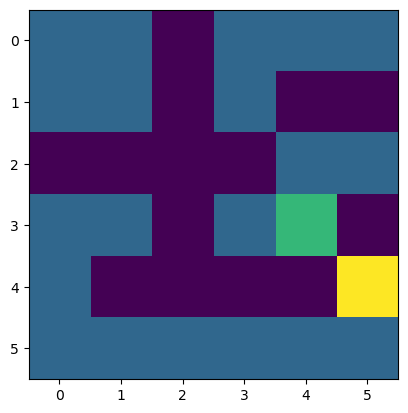

In [20]:
import numpy as np
from matplotlib import pyplot as plt

occupancy = np.array([
    [1, 1, 0, 1, 1, 1],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 1],
    [1, 1, 0, 1, 2, 0],
    [1, 0, 0, 0, 0, 3],
    [1, 1, 1, 1, 1, 1]
])

plt.imshow(occupancy)




In [27]:
def generate_graph_edges(occupancy, with_diag=False):
    wx, hy = occupancy.shape
    steps = [
        np.array([np.cos(np.pi/2 * i), np.sin(np.pi/2 * i)])
        for i in range(2)
    ]
    if with_diag:
        steps += [
            np.array([np.cos(np.pi/2 * i + np.pi/4), np.sin(np.pi/2 * i + np.pi/4)]) * np.sqrt(2)
            for i in range(2)
        ]
    steps = np.array(steps).astype(int)
    edges = []
    
    for y in range(hy):
        for x in range(wx):
            if occupancy[x, y] == 0:
                continue
            for (dx, dy) in steps:
                x2 = x + dx
                y2 = y + dy
                x_in = (0 <= x2 < wx)
                y_in = (0 <= y2 < hy)
                if not (x_in and y_in):
                    continue
                
                if occupancy[x2, y2]:
                    edges.append(
                        ((x, y), (x2, y2))
                    )
    return edges
        

In [31]:
def plot_edges(ed):
    for v0, v1 in ed:
        plt.plot(
            [v0[1], v1[1]],
            [-v0[0], -v1[0]],

            '-b'
        )
        wx, hy = occupancy.shape

    x = np.arange(0, wx)
    y = np.arange(0, hy)
    xv, yv = np.meshgrid(x, y)
    plt.plot(xv, -yv, marker='o', color='k', linestyle='none')



In [30]:
ed_sq = generate_graph_edges(occupancy, with_diag=False)
ed_diag = generate_graph_edges(occupancy, with_diag=True)


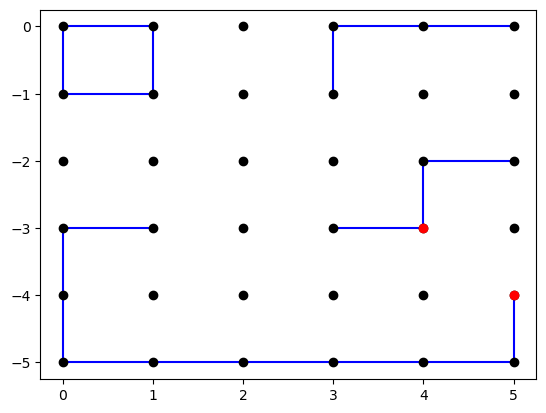

In [35]:
plot_edges(ed_sq)
plt.plot([4, 5], [-3, -4], 'ro')

# DFS (square)
- (3, 4)
- (2, 4)
- (2, 5)
- (3, 3)
- END


# BFS (square)
- (3, 4)
- (2, 4)
- (3, 3)
- (2, 5)
- END

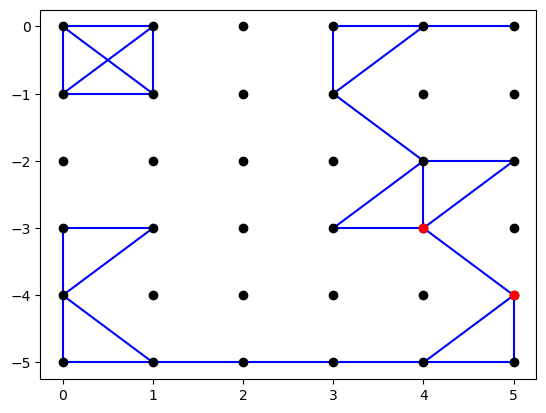

In [36]:
plot_edges(ed_diag)
plt.plot([4, 5], [-3, -4], 'ro')

# DFS (diag)
- (3, 4)
- (2, 5)
- (2, 4)
- (1, 3)
- (0, 4)


# BFS (diag)
- (3, 4)
- (2, 5)
- (3, 3)
- (1, 3)
- (4, 5) <- B


# Implementing the A-star algorithm (50 pts)

In this coding assignment, you will implement the A-star algorithm to search a maze. A maze is represented as an array of 0s and 1s. A cell in the maze is occupied if it is marked "1" and unoccupied if it is marked "0". The A-star algorithm will find the shortest path from A to B. The maze, along with the start and end positions are listed in the main() function.

A few IMPORTANT notes:
- A position in the maze is given by (x,y). As in lecture, x is the horizontal position along the maze, and y is the vertical position.
- Indexing in python starts from 0. Thus, in the given maze, (0,0) represents the bottom left cell and (9,9) represents the top right cell. As another example, (9,0) represents the right most cell at the bottom. 
- For simplicity, we will make A-star find the shortest path in the maze from A to B. Thus, the cost l(x, x') associated with an edge between x and x' will simply be 1.

We have provided a number of helper functions for you (see below) and have also completed some portions of the code. You will complete the portions marked "TO DO". The code will return a path from A to B that avoids the obstacle cells. It may be helpful to refer to the slides from Lecture 7 posted on Canvas; the slides contain pseudocode.



In [6]:
import numpy as np

In [7]:
############################## DO NOT MODIFY (but please read) ##############################################
# These are helper functions 

class Vertex():
    """A class for vertices"""

    def __init__(self, parent=None, position=None, ):
        self.parent = parent # Keeps track of parent of a vertex
        self.position = position # Keeps track of position of a vertex

        self.C = float('inf') # Estimate of cost-to-come
        self.H = 0 # Heuristic
    
    @property
    def F(self):
        # F = C + H (as in class)
        return self.C + self.H

    def __eq__(self, other): # Allows you to check if two vertices are the same by doing "vertex_1 == vertex_2"
        return self.position == other.position     
    
def getNeighbors(x_vertex, maze):
    """Get neighbors of x_vertex"""
    neighbors = []
    for new_position in [(-1, 0), (0, 1), (1,0), (0,-1)]: # Adjacent vertices

        # Get node position
        vertex_position = (x_vertex.position[0] + new_position[0], x_vertex.position[1] + new_position[1])

        # Make sure it is within range
        if (vertex_position[0] > (len(maze) - 1) or vertex_position[0] < 0) or (
            vertex_position[1] > (len(maze[len(maze)-1]) -1) or vertex_position[1] < 0):
            continue

        # Make sure it is not occupied by an obstacle
        if maze[len(maze)-vertex_position[1]-1][vertex_position[0]] != 0:
            continue

        # Create new vertex
        new_vertex = Vertex(None, vertex_position)

        # Append
        neighbors.append(new_vertex)
        
    return neighbors
############################################################################################################




################ TO DO: FILL THIS IN #####################################################
def GetBestVertex(Q):
    """Get the vertex "x_vertex" in Q that has the lowest value of F"""
    """Returns x_vertex and the index of x_vertex in Q"""
    q_f = [q.F for q in Q]
    x_index = np.argmin(q_f)
    x_vertex = Q[x_index]
    return x_vertex, x_index 


def computeH(vertex, B_vertex):
    """Function for computing heuristic H(vertex). To compute H(vertex), use computeH(vertex,B_vertex)"""
    """Recall that the heuristic is an underestimate of the cost-to-go from a vertex to the goal"""
    """You can use the heuristic we discussed in class. You can try other heuristics too if you are curious."""
    return abs(B_vertex.position[0] - vertex.position[0]) + abs(B_vertex.position[1] - vertex.position[1])
##########################################################################################


######### This is the function that implements A star; you will fill in parts of this #########
def astar(maze, A, B):
    """Returns a list of tuples as a path from A to B in the given maze"""
    
    ############################## DO NOT MODIFY ##############################################
    # Create start and end vertices
    A_vertex = Vertex(None, A) 
    B_vertex = Vertex(None, B)
    A_vertex.C = 0
    A_vertex.H = computeH(A_vertex, B_vertex)
    #A_vertex.F = A_vertex.H

    # Initialize Q and "dead" state list
    Q = []
    Q.append(A_vertex)
    DeadSet = []
    ############################################################################################

    # Loop until you get to the goal
    while len(Q) > 0:

        ################ TO DO: IMPLEMENT GetBestVertex(Q) #####################################
        # Get the current vertex: "x_vertex", i.e., the one that has the lowest value of F
        x_vertex, x_index = GetBestVertex(Q) # Implement this function
        ########################################################################################

        ################### DO NOT MODIFY THIS ##############################################
        # Check if we are at the goal vertex B
        if x_vertex == B_vertex:
            # If we are, backtrack to get the path
            path = []
            current = x_vertex
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path
        #####################################################################################
        
        ########################### TO DO ############################################
        # Remove x_vertex from Q, add to dead list
        Q.pop(x_index)
        DeadSet.append(x_vertex)
        #####################################################################################

        ################### DO NOT MODIFY THIS ##############################################
        # Generate neighbors
        neighbors = getNeighbors(x_vertex, maze)
        #####################################################################################
        
        # TO DO: FILL THIS IN #############################
        # Loop through neighbors, update costs, etc.
        for x_prime in neighbors:
            if x_prime in DeadSet:
                continue
            maybe_new_C = x_vertex.C + 1
            if maybe_new_C < x_prime.C:
                x_prime.C = maybe_new_C
                x_prime.parent = x_vertex
                if x_prime not in Q:
                    Q.append(x_prime)
            
                
        ##########################################################
        
##############################################################################################        
        


In [16]:

############################## DO NOT MODIFY ##############################################
maze = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
    
A = (0, 0)
B = (2, 6)
    
path = astar(maze, A, B)
print(path)

    
############################################################################################    

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6)]


The cell below will visualize the path that your A-star implementation found. Obstacles are colored in purple, free cells are yellow, and the path is shown in green. 

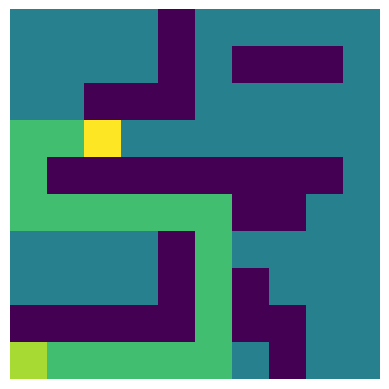

In [17]:
# This cell visualizes the path you found above
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

maze_modified = 1.0 - np.array(maze)
for v in path: 
    maze_modified[len(maze)-v[1]-1][v[0]] += 0.6
maze_modified[len(maze)-A[1]-1][A[0]] += 0.4
maze_modified[len(maze)-B[1]-1][B[0]] += 0.7
    
plt.imshow(maze_modified); # , cmap='hot');
plt.axis('off');
